In [1]:
import numpy as np
import plot
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches

In [2]:
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

rc('font',**{'family':'serif'})
rc('text', usetex=True)

In [3]:
ndim = 3
nwaves = 3

In [4]:
HM_data_EL = np.loadtxt('data/3D_historymatch_ellipsoid_samples.txt').reshape((nwaves*8000,4))
HM_data_HC = np.loadtxt('data/3D_historymatch_ellipsoid_samples.txt').reshape((nwaves*8000,4))
#HM_data_EL_12 = np.loadtxt('3D_historymatch_ellipsoid_12z.txt').reshape((nwaves*5000,4))
#HM_data_EL_test = np.loadtxt('data/3D_historymatch_ellipsoid_8z_test.txt').reshape((nwaves*5000,4))
#HM_data_HC = np.loadtxt('data/3D_historymatch_hypercube.txt').reshape((nwaves*5000,4))

HM_data_HC_w1 = np.loadtxt('data/3D_historymatch_hypercube_w1.txt')
HM_data_HC_w2 = np.loadtxt('data/3D_historymatch_hypercube_w2.txt')
HM_data_HC_w3 = np.loadtxt('data/3D_historymatch_hypercube_w3.txt')

HM_data_EL_w1 = np.loadtxt('data/3D_historymatch_ellipsoid_w1.txt')
HM_data_EL_w2 = np.loadtxt('data/3D_historymatch_ellipsoid_w2.txt')
HM_data_EL_w3 = np.loadtxt('data/3D_historymatch_ellipsoid_w3.txt')

#HM_data_EL_true_output = np.loadtxt('data/3D_historymatch_ellipsoid_8z_true_output.txt')
#HM_data_EL_emulator_output = np.loadtxt('data/3D_historymatch_ellipsoid_8z_emulator_output.txt')

HC_true_output = np.loadtxt('data/3D_HC_true_output.txt')
HC_emulator_output = np.loadtxt('data/3D_HC_emulator_output.txt')

Itrain = np.loadtxt('data/EL_Itrain.txt')
Idata = np.loadtxt('data/EL_Idata.txt')


analytic_mean = np.loadtxt("3D_analytic_mean.txt").reshape(3,)
analytic_cov = np.loadtxt("3D_analytic_cov.txt").reshape(3,3)
H = analytic_cov


155
(24000,)


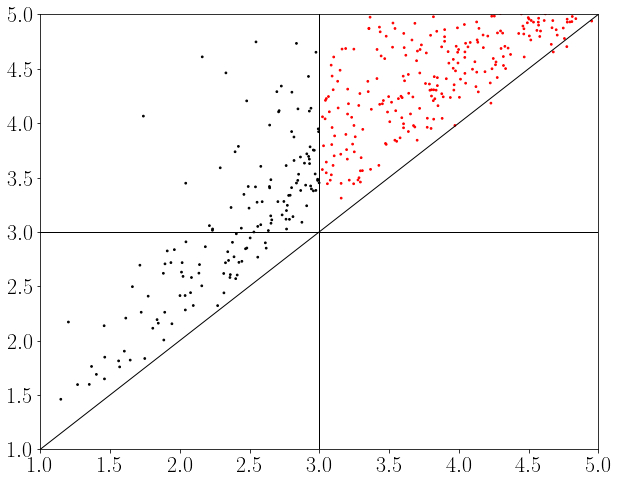

In [5]:
fig, ax = plt.subplots(figsize=(10,8))

col = np.where(Itrain[:8000]<3,'k','r')
print(len(np.where(Itrain[:8000]<3)[0]))

ax.scatter(Itrain[:8000], Idata[:8000], s=3, color=col)
x = np.linspace(0,40,100)
#ax.set_xlim([0,np.max(Itrain[:100])])
#ax.set_ylim([0,np.max(Idata[:100])])
ax.set_xlim([1,5])
ax.set_ylim([1,5])
ax.plot(x, x, color='black', linewidth=1)
ax.axvline(3, color='black', linewidth=1)
ax.axhline(3, color='black', linewidth=1)
print(Idata.shape)

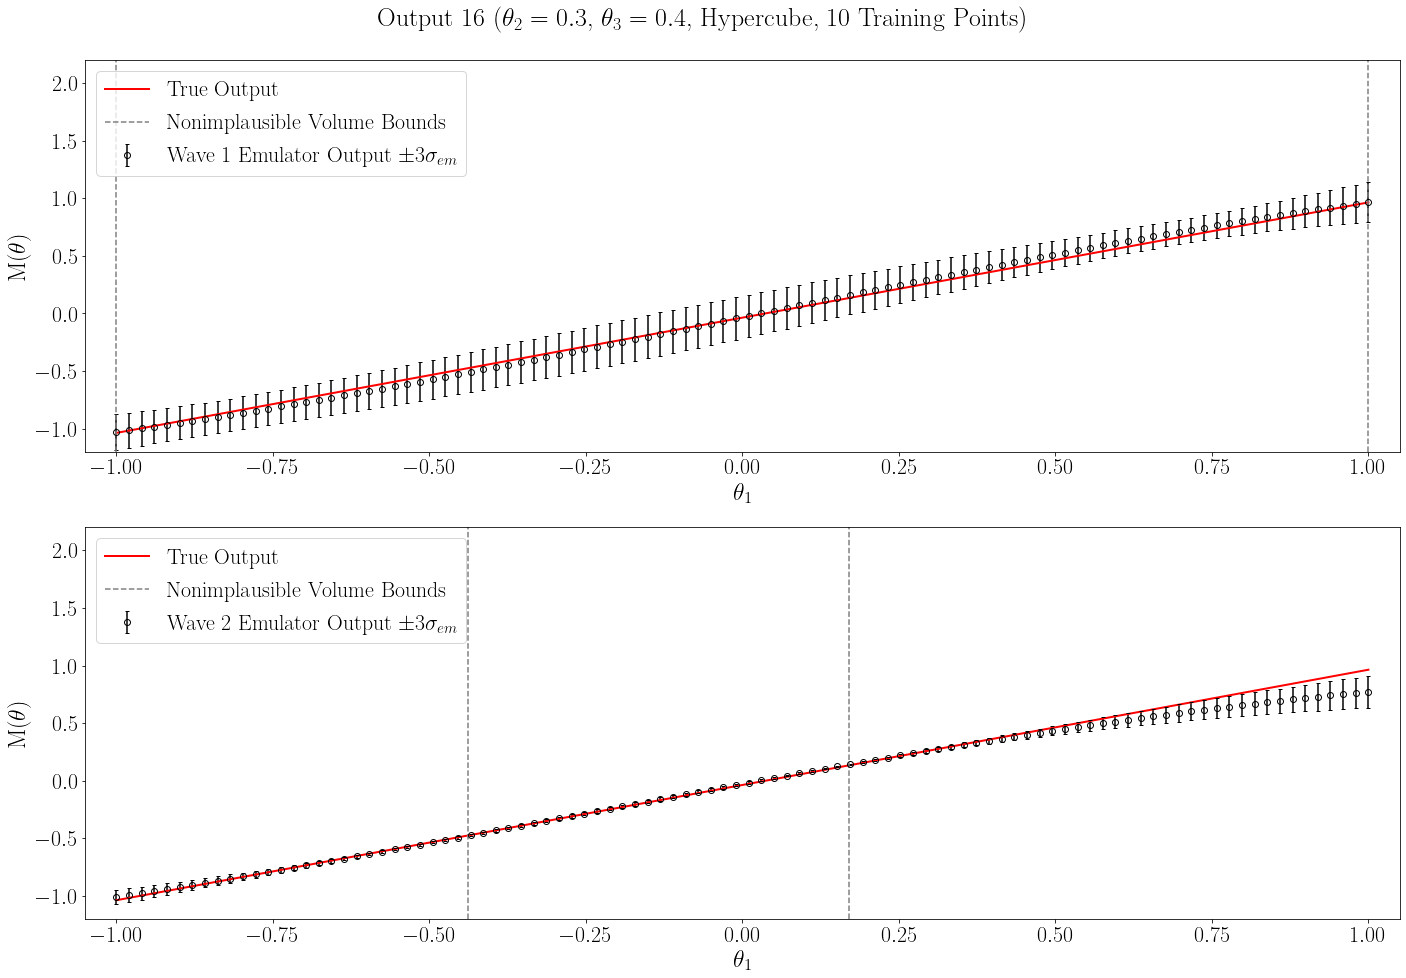

In [6]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,14))

#mu_EL = HM_data_EL_emulator_output[:,0][:100]
#sd_EL = HM_data_EL_emulator_output[:,0][:100]

mu_HC = HC_emulator_output[:,0]
sd_HC = HC_emulator_output[:,1]

ax1.plot(np.linspace(-1,1,100), HC_true_output[:100], linewidth=2, color = 'red', label='True Output')
ax1.errorbar(np.linspace(-1,1,100), mu_HC[:100], yerr=3*sd_HC[:100], color='black', fmt='o', mfc='None', capsize=2, label=r'Wave 1 Emulator Output $\pm 3\sigma_{em}$')
ax1.axvline(-1, color='grey', linestyle='--', label='Nonimplausible Volume Bounds')
ax1.axvline(1, color='grey', linestyle='--')
ax1.set_xlabel(r'$\theta_{1}$')
ax1.set_ylabel(r'M($\theta$)')
ax1.legend(loc='upper left')
ax1.set_ylim([-1.2,2.2])
ax1.set_xlim([-1.05,1.05])

ax2.plot(np.linspace(-1,1,100), HC_true_output[100:200], linewidth=2, color = 'red', label='True Output')
ax2.errorbar(np.linspace(-1,1,100), mu_HC[100:200], yerr=3*sd_HC[100:200], color='black', fmt='o', mfc='None', capsize=2, label=r'Wave 2 Emulator Output $\pm 3\sigma_{em}$')
ax2.axvline(np.min(HM_data_HC_w1[:,0].T[:-1]), color='grey', linestyle='--', label='Nonimplausible Volume Bounds')
ax2.axvline(np.max(HM_data_HC_w1[:,0].T[:-1]), color='grey', linestyle='--')
ax2.set_xlabel(r'$\theta_{1}$')
ax2.set_ylabel(r'M($\theta$)')
ax2.legend(loc='upper left')
ax2.set_ylim([-1.2,2.2])
ax2.set_xlim([-1.05,1.05])


fig.suptitle(r'Output 16 ($\theta_{2}=0.3$, $\theta_{3}=0.4$, Hypercube, 10 Training Points)')
plt.tight_layout()
#plt.savefig('figures/emulator_output_HC.png', bbox_inches='tight', facecolor='white', transparent=False)

In [7]:
#wave2_EL_8 = HM_data_EL_8[5000:10000]
#wave1_EL_8 = HM_data_EL_8[:5000]



#final_wave_EL_8 = HM_data_EL_8[(nwaves-1)*5000:]
#final_wave_EL_12 = HM_data_EL_12[(nwaves-1)*5000:]
#final_wave_EL_test = HM_data_EL_test[(nwaves-1)*5000:]

#wave1_HC = HM_data_HC[:5000]
#wave2_HC = HM_data_HC[5000:10000]

#final_wave_HC = HM_data_HC[(nwaves-1)*5000:]

In [8]:
theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)
parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)

In [9]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], linewidth='3', color=color)

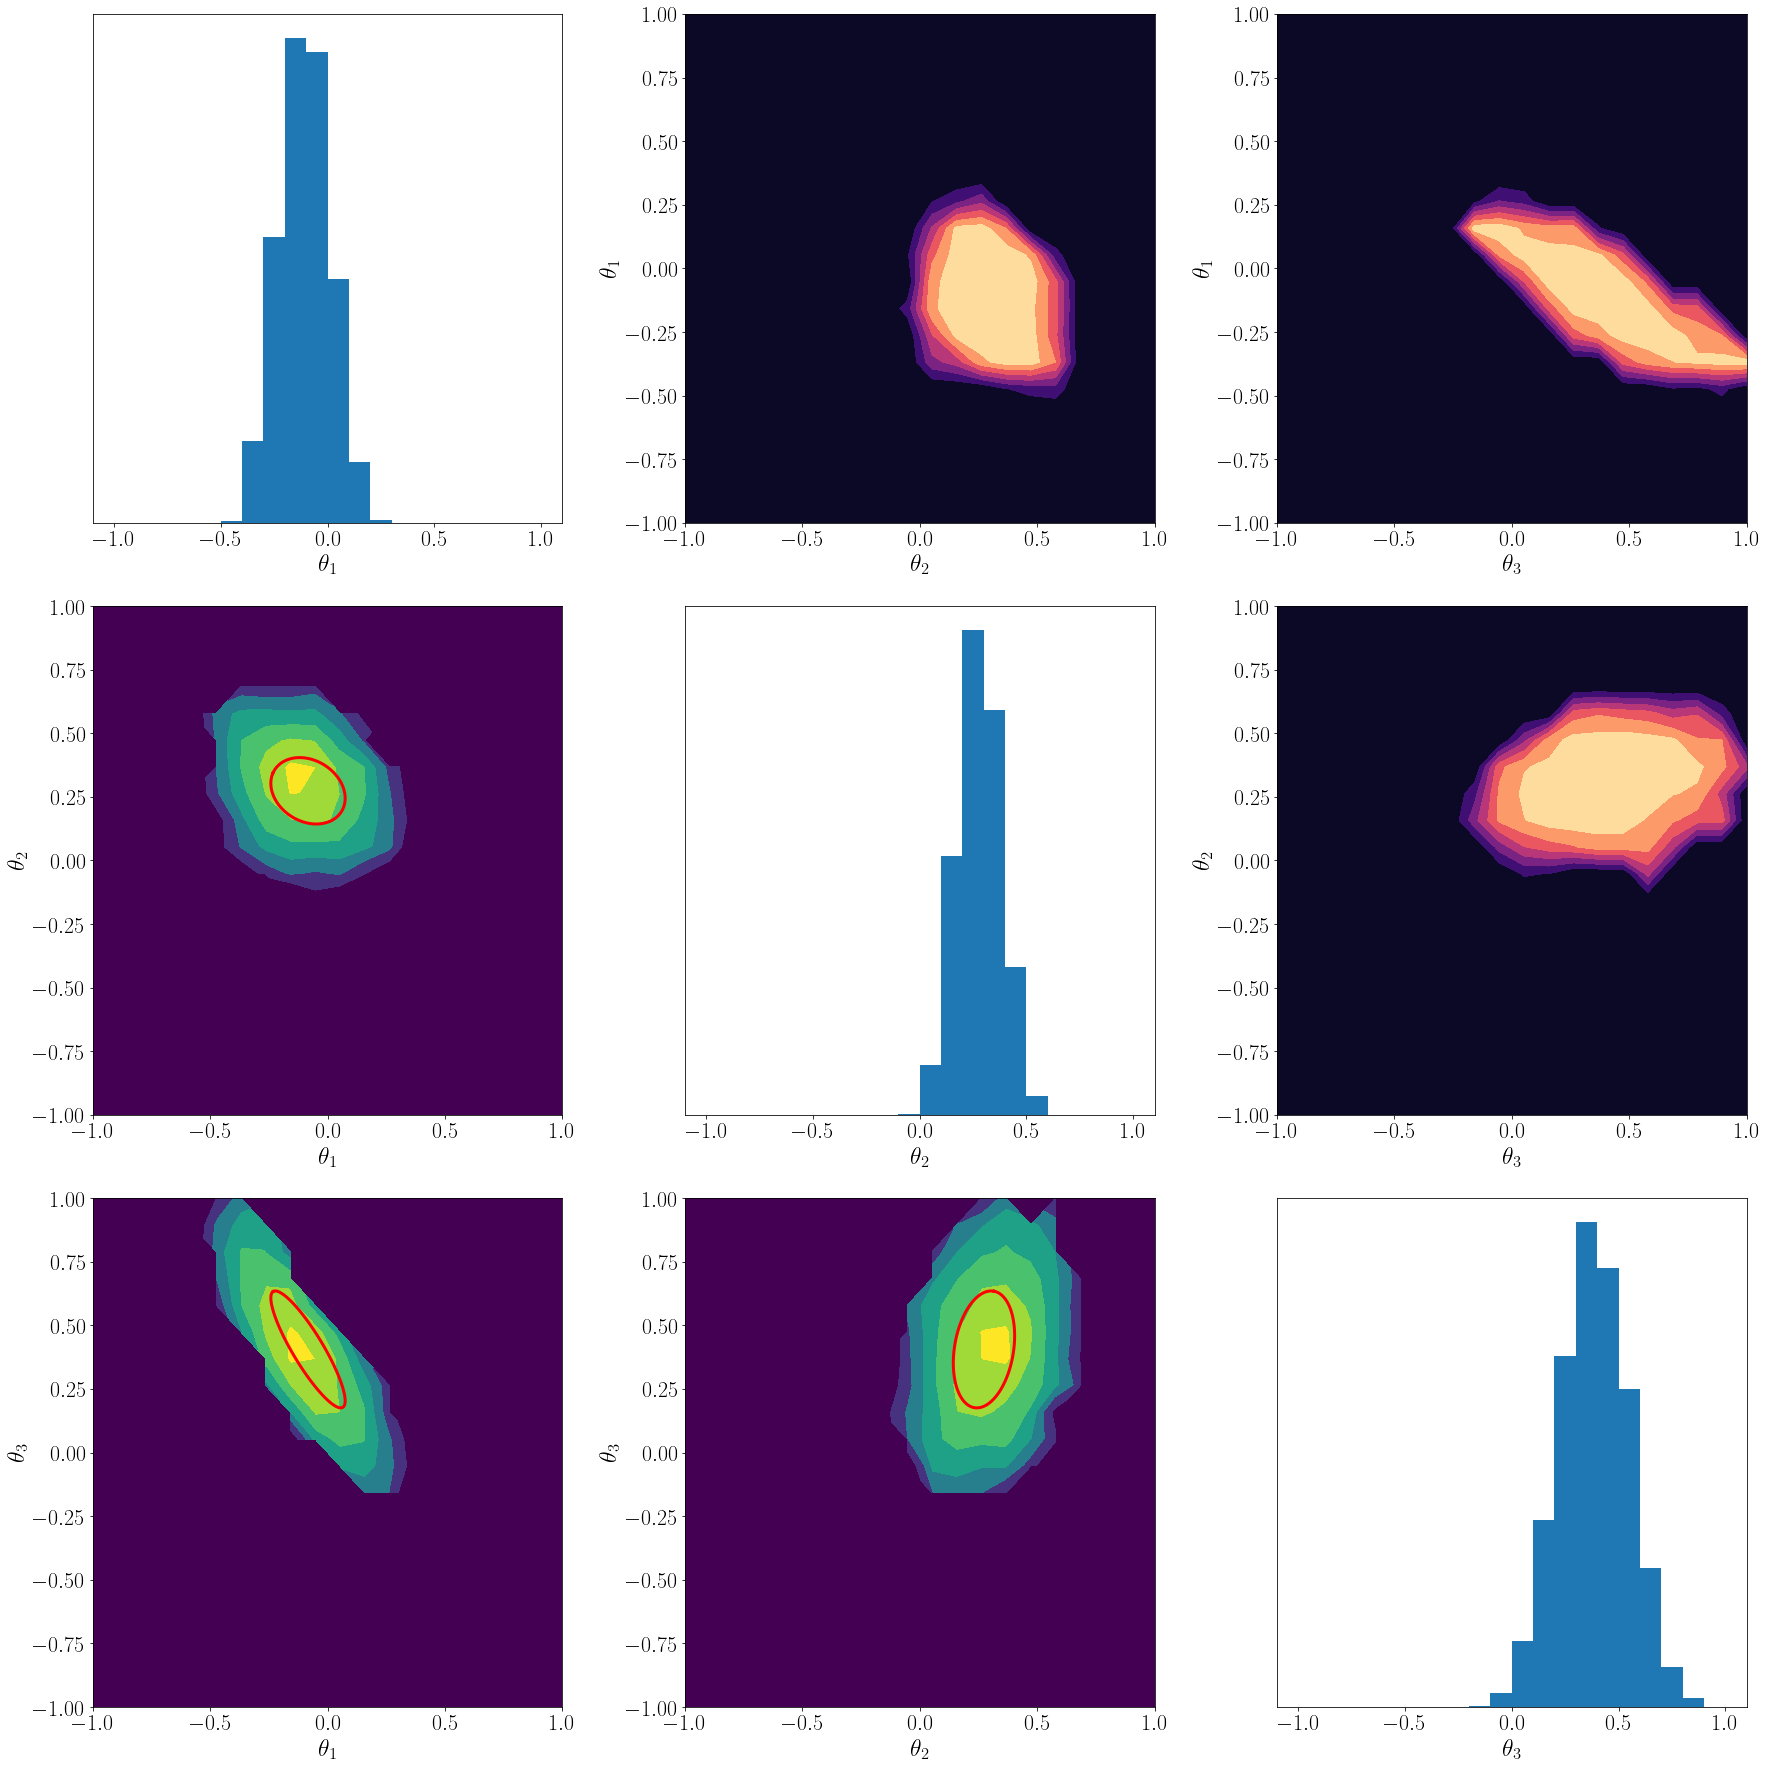

In [10]:
fig, axes = plt.subplots(ndim,ndim,figsize=(25,25))

plot.plotcorner(HM_data_EL[8000:16000], parameter_bounds, 3, Fig=(fig,axes), labels=(r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$'))
get_cov_ellipse(np.array([[H[0,0], H[0,1]],[H[1,0], H[1,1]]]), [analytic_mean[0], analytic_mean[1]], 3, axes[1,0], color = 'red')
get_cov_ellipse(np.array([[H[0,0], H[0,2]],[H[2,0], H[2,2]]]), [analytic_mean[0], analytic_mean[2]], 3, axes[2,0], color = 'red')
get_cov_ellipse(np.array([[H[1,1], H[1,2]],[H[2,1], H[2,2]]]), [analytic_mean[1], analytic_mean[2]], 3, axes[2,1], color = 'red')

#plt.savefig('figures/final_wave_corner', bbox_inches='tight', facecolor='white', transparent=False)

-0.0832421425144813
-0.42272421875
0.2738720593225429
-0.10600890624999995
0.40537014223043655
-0.2754294531249999


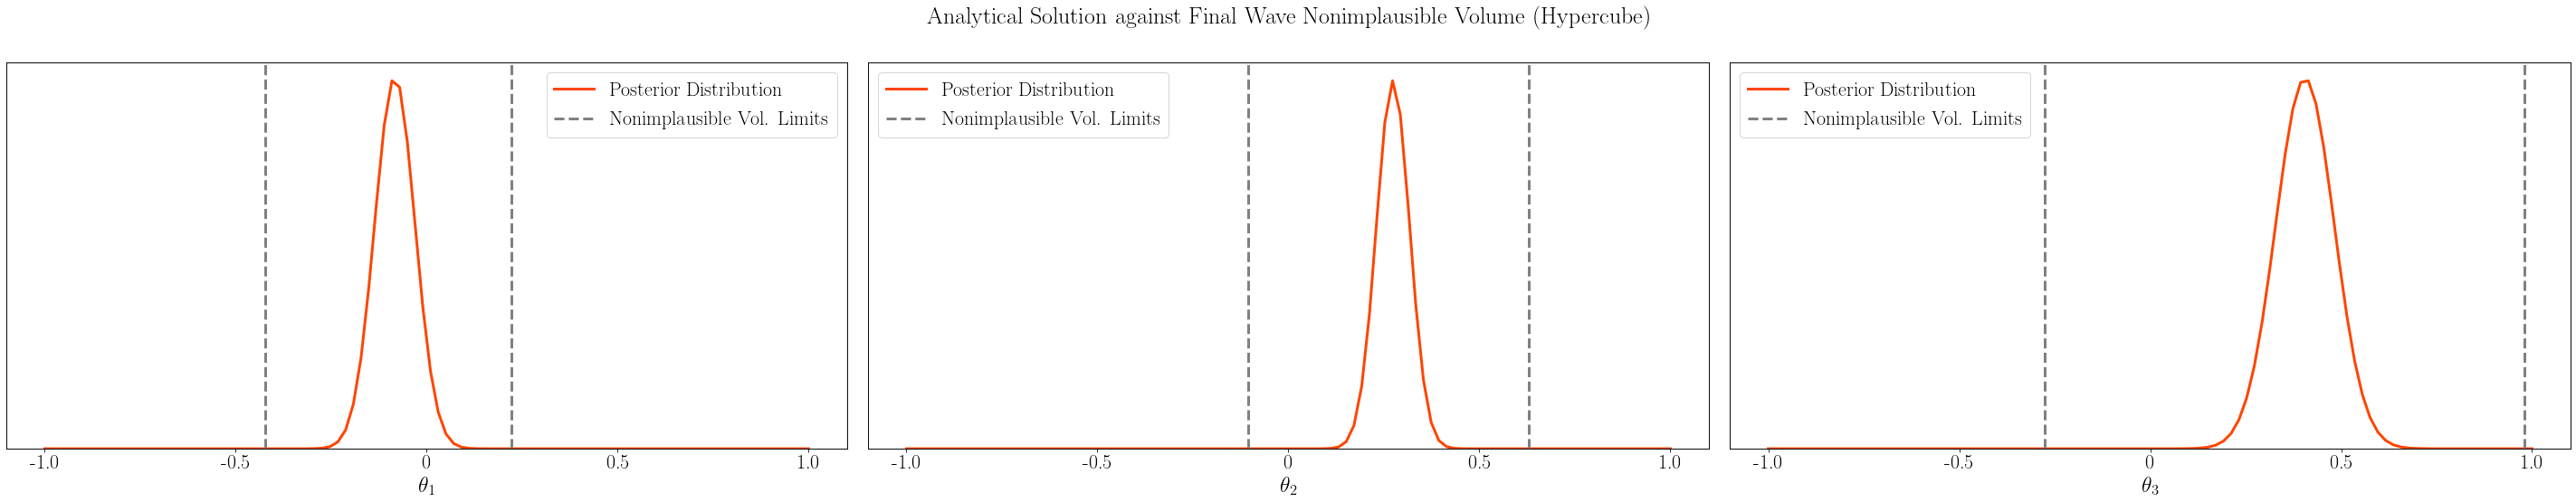

In [10]:
fig, axes = plt.subplots(1,3,figsize=(40,8))
theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']
#ax1_right = ax1.twinx()

for i in range(ndim):
    ax_right = axes[i].twinx()
    print(analytic_mean[i])
    #plot.opticaldepth_1D(final_wave_HC, parameter_bounds[i], i, bins=50, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i], np.sqrt(H[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    
    min_theta3 = np.min(HM_data_HC_w2[:,i].T[:-1])
    max_theta3 = np.max(HM_data_HC_w2[:,i].T[:-1])
    
    min_theta1 = np.min(HM_data_HC_w1[:,i].T[:-1])
    max_theta1 = np.max(HM_data_HC_w1[:,i].T[:-1])
    
    min_theta2 = np.min(HM_data_HC_w3[:,i].T[:-1])
    max_theta2 = np.max(HM_data_HC_w3[:,i].T[:-1])
    
    print(np.min(HM_data_HC_w2[:,i].T[:-1]))

    
    #ax_right.axvline(max_theta1, color='cornflowerblue', linestyle='--', linewidth=3, label=r'Wave 1 Nonimplausible Vol. Limits')
    #ax_right.axvline(max_theta2, color='orange', linestyle='--', linewidth=3)
    ax_right.axvline(max_theta3, color='grey', linestyle='--', linewidth=3, label=r'Nonimplausible Vol. Limits')
    
    #ax_right.axvline(min_theta1, color='cornflowerblue', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta2, color='orange', linestyle='--', linewidth=3)
    ax_right.axvline(min_theta3, color='grey', linestyle='--', linewidth=3)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i])
    #ax_right.tick_params(right=False)
    
    axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    handles, labels = ax_right.get_legend_handles_labels()
    #patch = mpatches.Patch(color='lightblue', label='Optical Depth')
    #handles.append(patch) 
    plt.legend(handles=handles, loc='best')
    
    
fig.suptitle('Analytical Solution against Final Wave Nonimplausible Volume (Hypercube)')
plt.tight_layout()

#plt.savefig('figures/final_1D_plot_HC_2ndI.png', bbox_inches='tight', facecolor='white', transparent=False)


In [12]:
HM_cov_w1 = np.cov(HM_data_EL_w1.T[:-1])
HM_mean_w1 = np.mean(HM_data_EL_w1.T[:-1], axis=1)

HM_cov_w2 = np.cov(HM_data_EL_w2.T[:-1])
HM_mean_w2 = np.mean(HM_data_EL_w2.T[:-1], axis=1)

HM_cov_w3 = np.cov(HM_data_EL_w3.T[:-1])
HM_mean_w3 = np.mean(HM_data_EL_w3.T[:-1], axis=1)

#HM_cov_12 = np.cov(final_wave_EL_12.T[:-1])
#HM_mean_12 = np.mean(final_wave_EL_12.T[:-1], axis=1)

#HM_cov_test = np.cov(final_wave_EL_test.T[:-1])
#HM_mean_test = np.mean(final_wave_EL_test.T[:-1], axis=1)

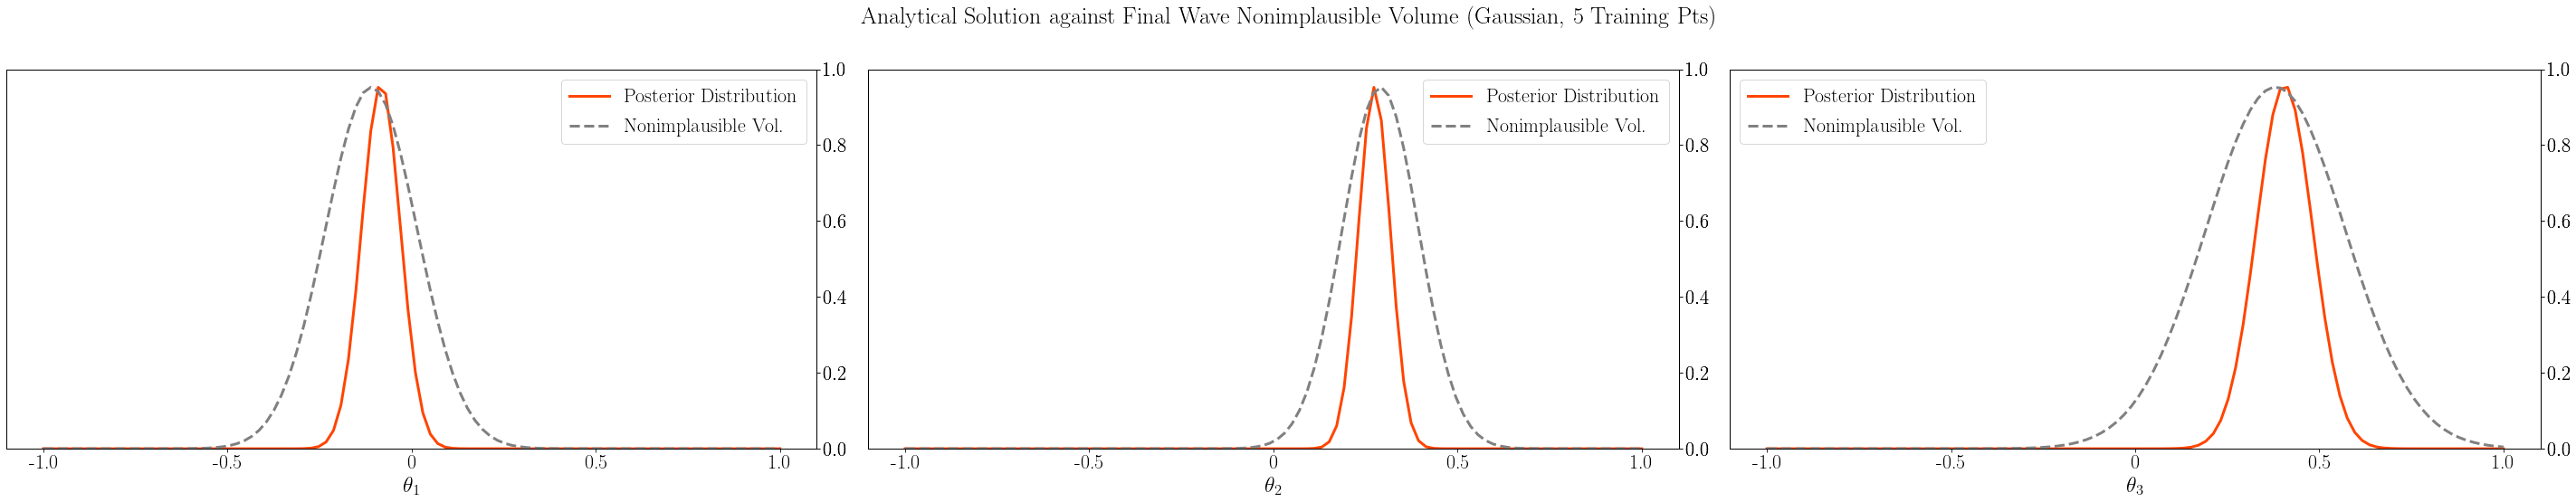

In [13]:
fig, axes = plt.subplots(1,3,figsize=(40,8))
theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']

for i in range(ndim):
    ax_right = axes[i].twinx()
    ax_right2 = axes[i].twinx()
    ax_right3 = axes[i].twinx()
    ax_right4 = axes[i].twinx()
    #plot.opticaldepth_1D(final_wave_EL, parameter_bounds[i], i, bins=80, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i], np.sqrt(H[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    ax_right2.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], HM_mean_w3[i], np.sqrt(HM_cov_w3[i,i])), color='grey', linestyle='--', linewidth=3, label='Nonimplausible Vol.')

    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    ax_right2.set(yticklabels=[])  
    ax_right2.tick_params(right=False)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    ax_right2.set_ylim([0, None])
    ax_right3.set_ylim([0, None])
    ax_right4.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i])
    #ax_right.tick_params(right=False)
    
    axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    lines, labels = ax_right.get_legend_handles_labels()
    lines2, labels2 = ax_right2.get_legend_handles_labels()
    #lines.append(mpatches.Patch(color='lightblue'))
    #labels.append('Optical Depth')
    ax_right2.legend(lines + lines2, labels + labels2, loc=0)

    
    
fig.suptitle('Analytical Solution against Final Wave Nonimplausible Volume (Gaussian, 5 Training Pts)')
plt.tight_layout()

#plt.savefig('figures/final_1D_plot_EL_5pts.png', bbox_inches='tight', facecolor='white', transparent=False)

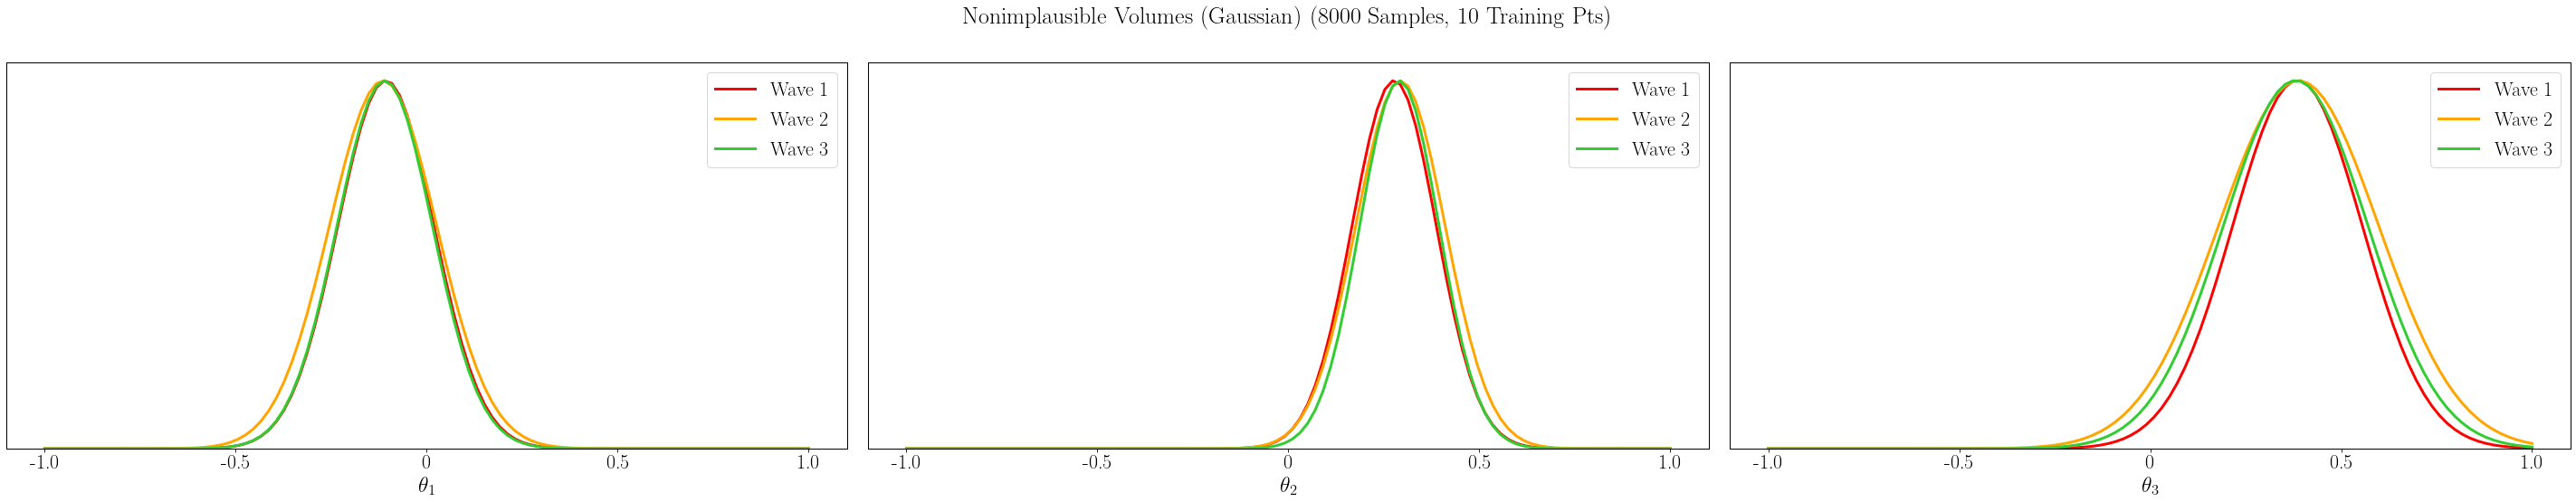

In [14]:
fig, axes = plt.subplots(1,3,figsize=(40,8))
theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']

for i in range(ndim):
    ax_right = axes[i].twinx()
    ax_right2 = axes[i].twinx()
    ax_right3 = axes[i].twinx()
    ax_right4 = axes[i].twinx()

    ax_right2.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], HM_mean_w1[i], np.sqrt(HM_cov_w1[i,i])), color='red', linewidth=3, label='Wave 1')
    ax_right3.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], HM_mean_w2[i], np.sqrt(HM_cov_w2[i,i])), color='orange', linewidth=3, label='Wave 2')
    ax_right4.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], HM_mean_w3[i], np.sqrt(HM_cov_w3[i,i])), color='limegreen', linewidth=3, label='Wave 3')
    
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    ax_right2.set(yticklabels=[])  
    ax_right2.tick_params(right=False)
    ax_right3.set(yticklabels=[])  
    ax_right3.tick_params(right=False)
    ax_right4.set(yticklabels=[])  
    ax_right4.tick_params(right=False)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    ax_right2.set_ylim([0, None])
    ax_right3.set_ylim([0, None])
    ax_right4.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i])
    #ax_right.tick_params(right=False)
    
    axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    lines, labels = ax_right2.get_legend_handles_labels()
    lines2, labels2 = ax_right3.get_legend_handles_labels()
    lines3, labels3 = ax_right4.get_legend_handles_labels()
    #lines.append(mpatches.Patch(color='lightblue'))
    #labels.append('Optical Depth')
    ax_right2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

    
    
fig.suptitle('Nonimplausible Volumes (Gaussian) (8000 Samples, 10 Training Pts)')
plt.tight_layout()

#plt.savefig('figures/wave_plots_EL_5pts.png', bbox_inches='tight', facecolor='white', transparent=False)